# TMSMM PROJECT

## Sentimental Classification Analysis on Twitter tweets about Covid
##### Nomin Batbayar 442627 
    

### INTRODUCTION

In this project I will analyze the sentiment of Twitter tweets about Coronavirus. Dataset used in the project is provided with manually tagged Sentiment classes. So that I will try to train a Convolution Neural Network model to classify the Sentiment and experiment with pretrained word embedding.

This project aims to do the followings:
* Clean and prepare the texts
* Some Visualization
* Word embedding using the pretrained word embedding by Stanford's Glove
* Train Convolutional Neural Network with 2 classes
* Train CNN expanded with LSTM to compare the results
* Test the models and evaluate the results

In [1]:
# libraries
import numpy as np
np.random.seed(32)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statistics

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Conv1D, Dropout, Dense, Input, Flatten, Conv1D,  Embedding
from keras.layers import GlobalAveragePooling1D,GlobalMaxPooling1D, MaxPool1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stop=set(stopwords.words('english')) 

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


###  DATA

I use Twitter tweets about Covid dataset from [Kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification). Dataset was provided with both training and testing samples of 41'157 and 3'798 observation. Before dividing the data into final train and test data set, I combined the 2 datasets to do cleaning and preprocessing steps.
Initially dataset has 6 columns of variable, but I will only consider the text and Sentiment tag. 

Sentiment tag has 5 class:

"Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive" 

I will further train model with 2 class, combining negative classes, positive classes and excluding neutral class

In [2]:
train = pd.read_csv("C:/Users/nomin/OneDrive/Desktop/DSBA/3.6. Text mining and social media mining/project/Corona_NLP_train.csv", encoding='latin')
test = pd.read_csv("C:/Users/nomin/OneDrive/Desktop/DSBA/3.6. Text mining and social media mining/project/Corona_NLP_test.csv", encoding='latin')

comb = pd.concat([train, test])
data=comb[["OriginalTweet", "Sentiment"]]
data=data.rename(columns={'OriginalTweet': 'text', 'Sentiment': 'tag'})
data['tag2']=data['tag']
data.loc[data['tag']=="Extremely Negative", "tag2"]="Negative"
data.loc[data['tag']=="Extremely Positive", "tag2"]="Positive"

data.head()

,text,tag,tag2
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral
1,advice Talk to your neighbours family to excha...,Positive,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive,Positive
3,My food stock is not the only one which is emp...,Positive,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative


### Cleaning

In this section, I will clean, prepare the texts and make it ready for further analysis. I did following transformations to the text.
* removal of links and mentions
* lowercase all words and 
* removed some special characters
* removed unnecessary white spaces
* substitute each numbers with white spaces
* substitute some contractions with it's full form

In [3]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [4]:
my_punctuation = '!"$%&\'()*#+,.-/:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = re.sub('&amp;', 'and', tweet)
    tweet = re.sub("let's", 'let us', tweet)
    tweet = re.sub("'s", ' is', tweet)
    tweet = re.sub("'re", ' are', tweet)
    tweet = re.sub("ain't", 'am not', tweet)
    tweet = re.sub("won't", 'will not', tweet)
    tweet = re.sub("don't", 'do not', tweet)
    tweet = re.sub("n't", ' not', tweet)
    tweet = re.sub("'ve", ' have', tweet)
    tweet = re.sub("y'all", "you all", tweet)
    tweet = re.sub("'ll", ' will', tweet)
    tweet = re.sub("i'd", 'i would', tweet)
    tweet = re.sub("i'm", 'i am', tweet)
    tweet = re.sub('covid\S*', 'coronavirus', tweet)
    tweet = re.sub('corona\S*', 'coronavirus', tweet)
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('([0-9]+)', ' ', tweet) # remove numbers
    tweet = re.sub('#', '', tweet)
    tweet = re.sub(r'\[', '', tweet)
    tweet = re.sub(r'\]', '', tweet)
    tweet = re.sub('â\\x92', "'", tweet)
    tweet = re.sub('â\S+', '', tweet)
    tweet = re.sub('\.+', '.', tweet)
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    return tweet

In [5]:
data['text2'] = data.text.apply(clean_tweet)
data['text2']=data['text2'].str.strip()

Here are couple of examples after the cleaning process.

In [6]:
print("EXAMPLE 1")
print("Original: \n", data['text'].iloc[29])
print("------")
print("Cleaned: \n", data['text2'].iloc[29])
print("EXAMPLE 2")
print("Original: \n", data['text'].iloc[1000])
print("------")
print("Cleaned: \n", data['text2'].iloc[1000])

EXAMPLE 1
Original: 


#StockUp&amp;LockUp
------
Cleaned: 
 sealsoftheend soon with dwindling supplies unlawful panicky people will be breaking into closed stores and supermarkets to raid them as they normally do during a crisis so massive as the coronavirus stockupandlockup
EXAMPLE 2
Original: 




We're doing double - sometimes triple - what we normally do in daily sales. So, with that said (1/?)
------
Cleaned: 
 okay people with covid there is a few things i need to mention i work in a grocery store part of a large national chain right now we are pushed to our absolute limits we are doing double - sometimes triple - what we normally do in daily sales so with that said


### Visualization

Below I show sentiment class distribution. Looking at the frequency of the classes, the positive class was slightly frequent than the negative class.

C:\Users\nomin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nomin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


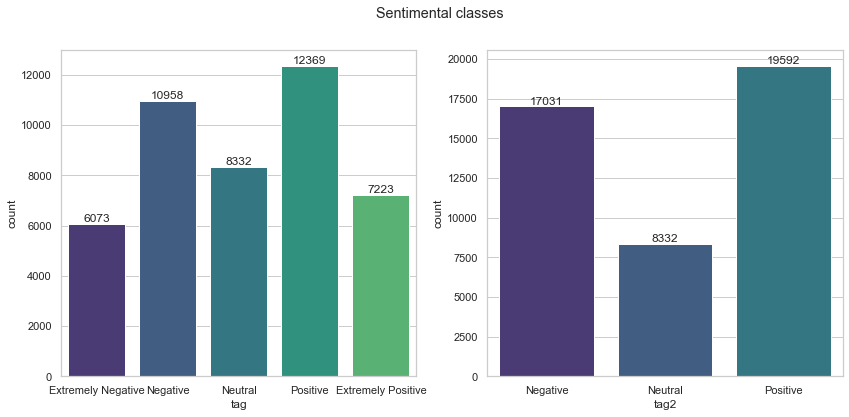

In [7]:
sns.set_theme(style="whitegrid", palette="viridis")

fig, axes = plt.subplots(1,2, figsize=(14, 6))
ax1=sns.countplot(data['tag'], 
                  order=["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"],
                  ax=axes[0])
ax1.bar_label(ax1.containers[0])

ax2=sns.countplot(data['tag2'], 
                  order=["Negative", "Neutral", "Positive"], 
                  ax=axes[1])
ax2.bar_label(ax2.containers[0])

fig.suptitle('Sentimental classes')
plt.show()

The following histogram shows how many words are in each tweets. On average, there are 30 words per sentence, with a maximum of 64 and a minimum of 1 word. Tweets with few words, fewer than 5 will not be used in the modeling.

MAX:  64 , AVG:  30 , MIN:  1


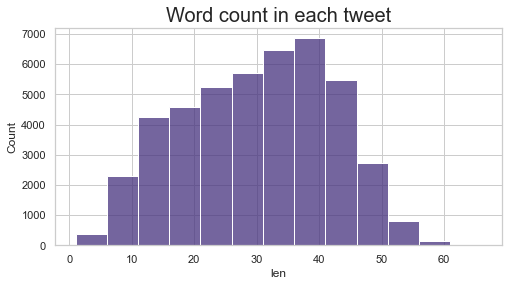

In [8]:
data['len']=data['text2'].str.count(' ')+1
print("MAX: ", max(data['len']), 
      ", AVG: ", round(statistics.mean(data['len'])), 
      ", MIN: ", min(data['len']))

plt.subplots(figsize=(8, 4))
ax = sns.histplot(data=data['len'], binwidth=5)
plt.title('Word count in each tweet', fontsize=20)
plt.show()


The following wordcloud shows the most frequently appeared words. The most trending words in these tweets are related to shopping and shortages of product.

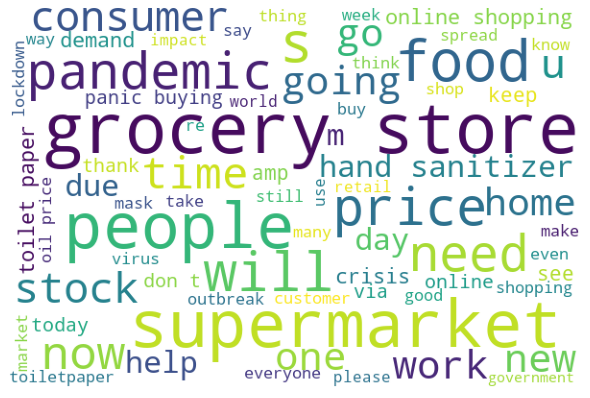

In [9]:
comment_words = '' 
stopwords = set(STOPWORDS)
stopwords.add("covid")
stopwords.add("covid covid")
stopwords.add("coronavirus")
stopwords.add("coronaviru")

for val in data['text2']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 600, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 15).generate(comment_words)
                     
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Precrocessing
 In the preprocessing step, I made some last transformations to make the dataset ready for the analysis. And divided into training and testing sample with 8:2 ratio.

In [10]:
data_2class=data.copy()
data_2class=data_2class[data_2class['tag2']!="Neutral"]
encoding={'Negative': 0, 'Positive': 1}
labels = ['Negative', 'Positive']
data_2class['tag2'].replace(encoding, inplace=True)

print(data_2class.shape)
data_2class.head()

(36623, 5)


,text,tag,tag2,text2,len
1,advice Talk to your neighbours family to excha...,Positive,1,advice talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,coronavirus australia woolworths to give elder...,13
3,My food stock is not the only one which is emp...,Positive,1,my food stock is not the only one which is emp...,43
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,me ready to go at supermarket during the covid...,41
5,As news of the regionÂs first confirmed COVID...,Positive,1,as news of the region s first confirmed covid-...,35


In [12]:
train_text, test_text, train_y, test_y = train_test_split(data_2class['text2'],data_2class['tag2'],test_size = 0.2)

In [13]:
y_train = train_y
y_test = test_y
y_train.shape
y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)
y_test.shape
y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (29298, 2)
Shape of label tensor: (7325, 2)


In [14]:
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

In [33]:
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 64

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 36195 unique tokens.


In [34]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [35]:
len(index_to_word)

36195

In [36]:
" ".join([index_to_word[i] for i in sequences[0]])

'how has the current situation affected you how have your habits changed what are you most looking forward to once lockdown is over we would love to hear from you our survey will only take a few minutes of your time thursdaythoughts changinghabits'

In [37]:
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (29298, 64)
Shape of data test tensor: (7325, 64)


In [38]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (29298, 2)


### Word Embedding

One challange when trainning a NLP models on Short texts instead of longer documents or articles, is that it lacks contextual informations. Which will lead to low prediction accuracy. So that using using larger corpus to use for word embedding is suggested by many researchers. So that I will be using pretrained Stanford's Glove word embedding for further analysis.

#### Stanford's Glove
Stanford's Glove embedding data downloaded from the official [website](https://nlp.stanford.edu/projects/glove/), I am using version with 400'000 words and each with 100 vectors.

In [40]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

In [41]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [42]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


So now I compute an indexing words to this pretrained embeddings. Below code is checking if a word is in the pretrained word embedding or not. And If this word exists in the embedding, the 100 vectors will be taken out from. 

In [43]:
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [44]:
embedding_matrix.shape

(36196, 100)

In [45]:
embedding_layer = Embedding(len(word_index)+1,
                            100,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Modeling

In this section, I will train CNN model, and CBOW model to check whether if using an pretrained word embedding increases performance, and also CNN expanded with LSTM to check, which model works best for this dataset and check if expanding CNN with LSTM model could increase the performance.


#### CNN 
I builded the CNN model with 4 layers. 
- Word embedding layer with pretrained Glove embedding
- 1 dimension Convolution layer with  5 vectors of 128 dimensional vectors
- Max Pooling layer
- and Softmax output layer

In [68]:
model=Sequential()
embedding_layer = Embedding(len(word_index)+1,
                            100,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(N_CLASSES, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [57]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=4, batch_size=128)

Epoch 1/4
206/206 [==============================] - 10s 44ms/step - loss: 0.5399 - acc: 0.7224 - val_loss: 0.4654 - val_acc: 0.7792
Epoch 2/4
206/206 [==============================] - 9s 43ms/step - loss: 0.4074 - acc: 0.8163 - val_loss: 0.4270 - val_acc: 0.7935
Epoch 3/4
206/206 [==============================] - 9s 43ms/step - loss: 0.3361 - acc: 0.8588 - val_loss: 0.4300 - val_acc: 0.7997
Epoch 4/4
206/206 [==============================] - 9s 43ms/step - loss: 0.2778 - acc: 0.8931 - val_loss: 0.4292 - val_acc: 0.8055


In [58]:
output_cnn = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_cnn[:,1]))

229/229 [==============================] - 2s 7ms/step
test auc: 0.9011548150942481


From CNN model results, model accuracy on training data is 0.89 and 0.80 on validation data. Area under curve measure is 0.90 on testing sample.

#### CBOW

I wanted to check if simple continous bag of words model without using the pretrained word embedding is perform worse than the pervious model. 

In [75]:
# A simple supervised CBOW model in Keras
N_CLASSES = 2
EMBEDDING_DIM=50
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer_cbow = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_cbow = embedding_layer_cbow(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences_cbow)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model_cbow = Model(sequence_input, predictions)
model_cbow.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [78]:
model_cbow.fit(x_train, y_train, validation_split=0.1, epochs=4, batch_size=128)

Epoch 1/4
206/206 [==============================] - 5s 25ms/step - loss: 0.2750 - acc: 0.9174 - val_loss: 0.3552 - val_acc: 0.8628
Epoch 2/4
206/206 [==============================] - 5s 25ms/step - loss: 0.2384 - acc: 0.9314 - val_loss: 0.3387 - val_acc: 0.8659
Epoch 3/4
206/206 [==============================] - 5s 25ms/step - loss: 0.2088 - acc: 0.9421 - val_loss: 0.3286 - val_acc: 0.8710
Epoch 4/4
206/206 [==============================] - 5s 25ms/step - loss: 0.1854 - acc: 0.9498 - val_loss: 0.3211 - val_acc: 0.8724


In [82]:
output_test_cbow = model_cbow.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test_cbow[:,1]))

229/229 [==============================] - 1s 2ms/step
test auc: 0.9332998438155


However, from CBOW model results, it is clear that this simple model performs better with model accuracy on training data is 0.95 and 0.87 on validation data, and area under curve measure is 0.93.

#### CNN-LSTM

Next I also wanted to check if expanding CNN model/ adding recurrent neural network architectures could improve model performance. 

In [80]:
# A more complex model : CNN - LSTM
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
#x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model_cnn_lstm = Model(sequence_input, predictions)
model_cnn_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [81]:
model_cnn_lstm.fit(x_train, y_train, validation_split=0.1,
          epochs=5, batch_size=128)

Epoch 1/5
206/206 [==============================] - 16s 57ms/step - loss: 0.5544 - acc: 0.7084 - val_loss: 0.5643 - val_acc: 0.7034
Epoch 2/5
206/206 [==============================] - 11s 51ms/step - loss: 0.4675 - acc: 0.7783 - val_loss: 0.4661 - val_acc: 0.7747
Epoch 3/5
206/206 [==============================] - 10s 50ms/step - loss: 0.4253 - acc: 0.8053 - val_loss: 0.4629 - val_acc: 0.7809
Epoch 4/5
206/206 [==============================] - 10s 51ms/step - loss: 0.3872 - acc: 0.8217 - val_loss: 0.4432 - val_acc: 0.7908
Epoch 5/5
206/206 [==============================] - 10s 51ms/step - loss: 0.3376 - acc: 0.8536 - val_loss: 0.4527 - val_acc: 0.7935


In [83]:
output_test_cnn_lstm = model_cnn_lstm.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test_cnn_lstm[:,1]))

229/229 [==============================] - 3s 10ms/step
test auc: 0.880252979622876


But, We can see from CNN-LSTM model results, model accuracy on training data is 0.85 and 0.79 on validation data, and area under curve measure is 0.88, which is quite lower than CNN model.

### CONCLUSION

Within the framework of this project, in order to reinforce what I learned from this course, sentiment classification were performed using CNN model with the data of short texts in Social Media.
The results of the analysis shows that my assumptions of improvement of performance when using pretrained word embedding and extending the model failed to be proved. It could be that the Glove word vector were calculated in 2014, and it might be outdated compared to the time of Corona virus. And it might be the case that I didn't play around the parameters enough. 